<h1 align="center">UCI machine-learning-databases/blood-transfusion</h1>

In [2]:
import numpy as np
import pandas as pd
%pylab inline
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# Getting the Data

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data'
data_df = pd.read_csv(url)

To demonstrate the RFMTC marketing model (a modified version of RFM), this study 
adopted the donor database of Blood Transfusion Service Center in Hsin-Chu City 
in Taiwan. The center passes their blood transfusion service bus to one 
university in Hsin-Chu City to gather blood donated about every three months. To 
build a FRMTC model, we selected 748 donors at random from the donor database. 
These 748 donor data, each one included R (Recency - months since last 
donation), F (Frequency - total number of donation), M (Monetary - total blood 
donated in c.c.), T (Time - months since first donation), and a binary variable 
representing whether he/she donated blood in March 2007 (1 stand for donating 
blood; 0 stands for not donating blood).


Attribute Information:

Given is the variable name, variable type, the measurement unit and a brief 
description. The "Blood Transfusion Service Center" is a classification problem. 
The order of this listing corresponds to the order of numerals along the rows of 
the database.

- R (Recency - months since last donation),
- F (Frequency - total number of donation),
- M (Monetary - total blood donated in c.c.),
- T (Time - months since first donation), and
- a binary variable representing whether he/she donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating blood).


In [4]:
data_df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [5]:
cols = [c.lower().split()[0] for c in data_df.columns]
cols[-1] = 'class_name'
data_df.columns = cols

In [6]:
data_df.head()

,recency,frequency,monetary,time,class_name
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [7]:
data_df.head()

,recency,frequency,monetary,time,class_name
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


# Check for Class Imbalance

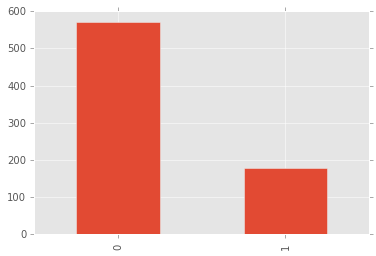

In [8]:
counts = data_df['class_name'].value_counts()
counts.plot(kind='bar')

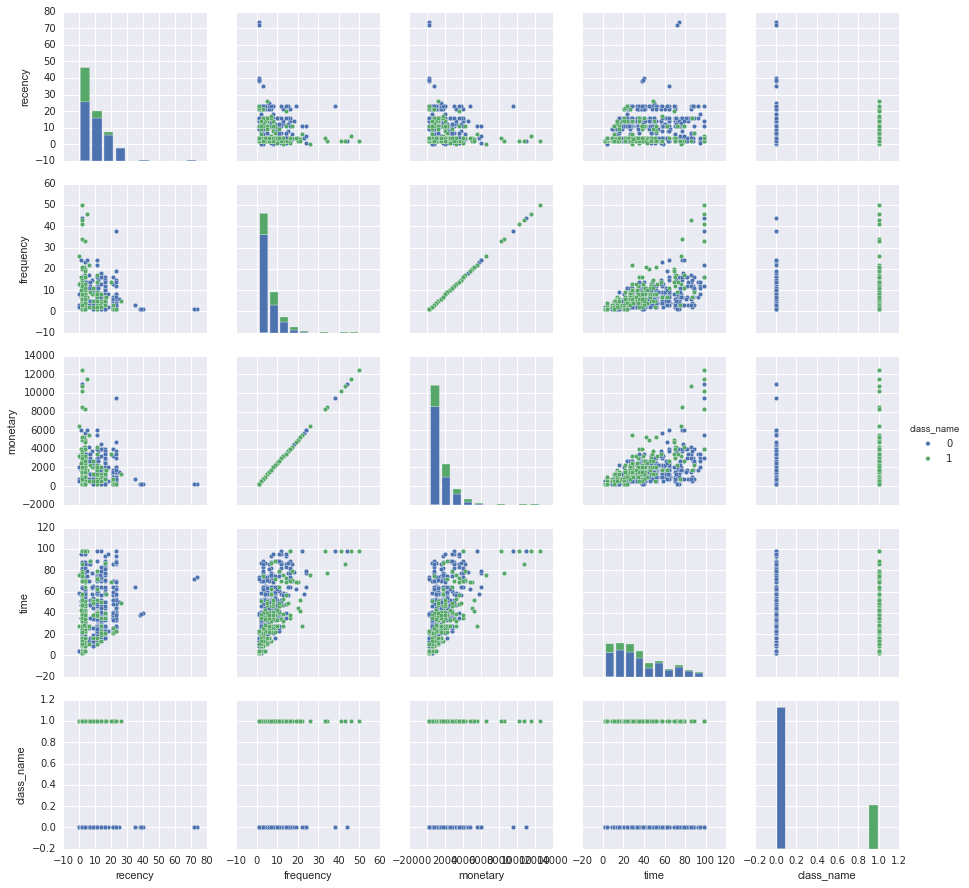

In [9]:
import seaborn as sns
sns.pairplot(data_df, hue='class_name')

# Feature Correlations

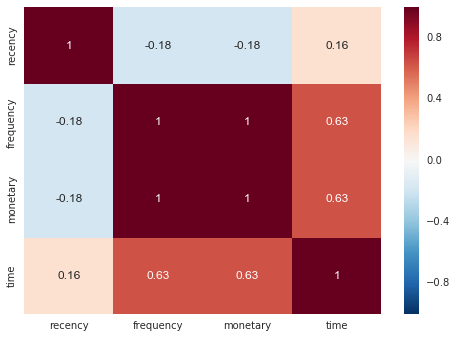

In [10]:
features = data_df.drop('class_name', axis=1)
labels = data_df['class_name']

corrs = features.corr()
sns.heatmap(corrs, annot=True)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

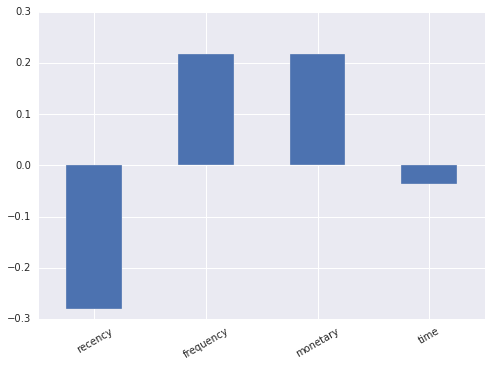

In [11]:
features.corrwith(labels).plot(kind='bar')
pylab.xticks(rotation=30)

# Feature Importances 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000014D828FC198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000014D845BF668>], dtype=object)

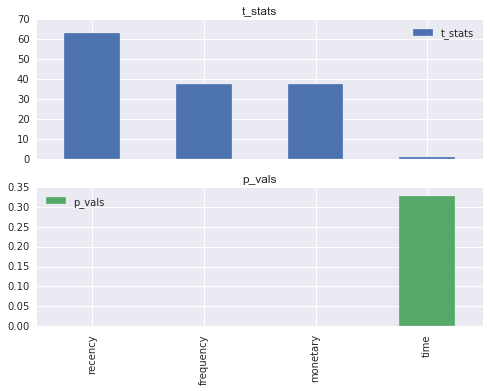

In [12]:
from sklearn.feature_selection import f_classif

t_stat, p_vals = f_classif(features, labels)
test_results = pd.DataFrame(np.column_stack([t_stat, p_vals]), 
                            index=features.columns.copy(),
                            columns=['t_stats', 'p_vals'])
test_results.plot(kind='bar', subplots=True)

# Approach 1: Gaussian Naive Bayes 

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold, cross_val_score

estimator = GaussianNB(priors=[0.5, 0.5])
kbest = SelectKBest(f_classif, k=2)
pipeline = Pipeline([('selector', kbest), ('model', estimator)])

cv = StratifiedKFold(n_splits=10, shuffle=True)
nb_scores = cross_val_score(pipeline, features, labels, cv=cv)
nb_scores = pd.Series(nb_scores)

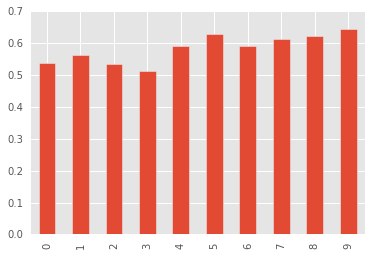

In [30]:
nb_scores.plot(kind='bar')

# Improving the Model

## Check for Underfit vs Overfit

Next, we compare train vs. test scores for each fold. 

* If train scores are higher than test scores, then the model is overfit.

* If both scores are nearly equal, it implies the model is not overfit. So we either need to give more data to each fold or use a different model.

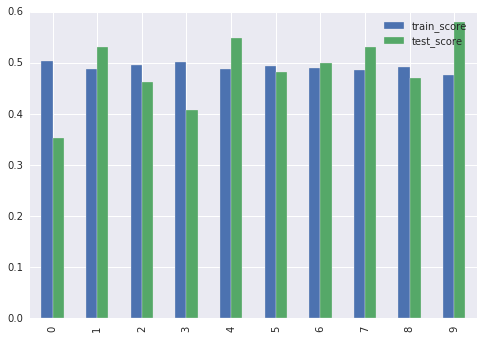

In [14]:
from sklearn.metrics import f1_score

def calc_scores(train_idx, test_idx):
    """Take train and test data for each CV fold and calculate scores for train and test splits."""
    train_data, train_labels = features.iloc[train_idx], labels.iloc[train_idx]
    test_data, test_labels = features.iloc[test_idx], labels.iloc[test_idx]
    
    estimator = GaussianNB(priors=[0.5, 0.5])
    kbest = SelectKBest(f_classif, k=2)
    pipeline = Pipeline([('selector', kbest), ('model', estimator)])
    
    pipeline = pipeline.fit(train_data, train_labels)
    train_score = f1_score(train_labels, pipeline.predict(train_data))
    test_score = f1_score(test_labels, pipeline.predict(test_data))    
    return (train_score, test_score)    
    return fold_scores
    
cv = StratifiedKFold(n_splits=10, shuffle=True)

fold_scores = [calc_scores(train_idx, test_idx) 
               for train_idx, test_idx 
               in cv.split(features, np.ones(len(features)))]

fold_scores = pd.DataFrame(fold_scores, columns=['train_score', 'test_score'])
fold_scores.plot(kind='bar')

In [15]:
fold_scores.mean()

train_score    0.491289
test_score     0.486531
dtype: float64

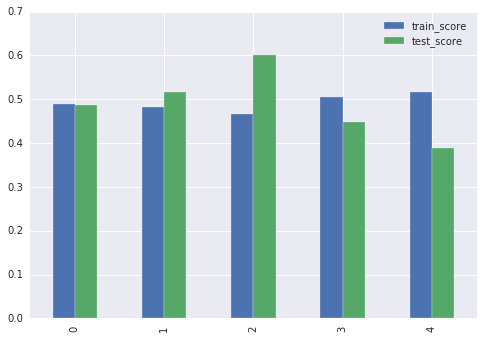

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

fold_scores = [calc_scores(train_idx, test_idx) 
               for train_idx, test_idx 
               in cv.split(features, np.ones(len(features)))]

fold_scores = pd.DataFrame(fold_scores, columns=['train_score', 'test_score'])
fold_scores.plot(kind='bar')

In [79]:
fold_scores.mean()

train_score    0.491963
test_score     0.486046
dtype: float64